In [2]:
import glob
import brainstat.datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import brainstat
import brainstat.datasets as datasets

from matplotlib.cm import ScalarMappable
from brainstat.datasets import fetch_yeo_networks_metadata
from brainstat.datasets import fetch_parcellation
from brainspace.utils.parcellation import map_to_labels
from brainstat.context.resting import yeo_networks_associations
from surfplot import Plot

from master_thesis.tools.plots.config import set_style, reset_style, COLUMN_HIGHT, COLUMN_WIDTH

lh, rh = brainstat.datasets.fetch_template_surface('fsaverage5', join=False)


RCC_LTP_DIRECTORY_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Results/lime/20240410-164742_RCC-LTP/explanations"
RCC_DIRECTORY_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Results/lime/20240522-195128_RCC-GCN/explanations"
GC_DIRECTORY_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Results/lime/20240522-195135_GC-GCN/explanations"
N_STDS = 0.002

xs_stroke_rcc = np.array([np.load(f) for f in glob.glob(RCC_DIRECTORY_PATH+"/*PAT*")])
xs_control_rcc = np.array([np.load(f) for f in glob.glob(RCC_DIRECTORY_PATH+"/*CON*")])

xs_stroke_gc = np.array([np.load(f) for f in glob.glob(GC_DIRECTORY_PATH+"/*PAT*")])
xs_control_gc = np.array([np.load(f) for f in glob.glob(GC_DIRECTORY_PATH+"/*CON*")])

xs_stroke_rcc_ltp = np.array([np.load(f) for f in glob.glob(RCC_LTP_DIRECTORY_PATH+"/*PAT*")])
xs_control_rcc_ltp = np.array([np.load(f) for f in glob.glob(RCC_LTP_DIRECTORY_PATH+"/*CON*")])

In [78]:
def interpretation_figure(explenations_array: np.ndarray, suffix: str, stroke: bool, n_stds: float = 3.0):

    # Fetch the schaefer parcellation and the yeo networks
    schaefer = datasets.fetch_parcellation('fsaverage5','schaefer',100)
    network_names, yeo_colormap = fetch_yeo_networks_metadata(7)

    # Aggregate the explanations

    # Calculate the mean and std of the non-zero explanations
    explenations_summed = explenations_array.sum(axis=0)
    explanations_nonzero = explenations_summed[explenations_summed != 0]
    mean, std = explanations_nonzero.mean(), explanations_nonzero.std()

    # Count connection with importance greater than the threshold
    if stroke:
        # print(mean + n_stds * std)
        thresholded = np.logical_and(explenations_summed > mean + n_stds * std, explenations_summed != 0)
    else:
        # print(mean - n_stds * std)
        thresholded = np.logical_and(explenations_summed < mean - n_stds * std, explenations_summed != 0)
    important_edges = np.where(thresholded, 1, 0)
    print(f"({suffix}) Ratio of important edges: {important_edges.sum() / 100}%")

    # The degree of each ROI reflects the number of important connections, hence the importance of the ROI
    roi_degrees = important_edges.sum(axis=0)

    # Map ROI degrees to the schaefer parcellation
    schaefer_surf = map_to_labels(roi_degrees, schaefer, mask=schaefer!=0).astype(float)

    # Map ROI degrees to the yeo networks and compute mean degree for each network
    yeo_tstat_mean = yeo_networks_associations(schaefer_surf, "fsaverage5", seven_networks=True, reduction_operation="mean")

    # Plot the results 
    # - plot the brain surface with the sum aggregated explanations
    reset_style()
    plt.rcParams.update({
        'font.size': 9,
        'font.family': 'serif',
        'font.serif': ["Times"],
    })
    plot = Plot(lh, rh)
    plot.add_layer(schaefer_surf, cbar=False)
    fig = plot.build()
    fig.savefig(f"xai_surfplot_{suffix}.pdf", bbox_inches="tight")
    plt.clf()

    # - plot the mean aggregated explanations for the yeo networks
    set_style()
    fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH, COLUMN_HIGHT))
    ax.bar(
        np.arange(7),
        yeo_tstat_mean[:, 0],
        color=yeo_colormap,
        error_kw={"elinewidth": 5},
    )
    ax.set_xticks(np.arange(7), network_names, rotation=90)
    # ax.set_yticks(fontsize=14)
    ax.set_ylabel("Mean degree")
    plt.savefig(f"xai_yeo_{suffix}.pdf", bbox_inches="tight")
    # plt.gcf().subplots_adjust(left=0.2, bottom=0.5)
    plt.clf()

In [79]:
N_STDS = 2.

interpretation_figure(xs_stroke_rcc, "stroke-rcc-gcn", True, N_STDS)
interpretation_figure(xs_control_rcc, "control-rcc-gcn", False, N_STDS)
interpretation_figure(xs_stroke_gc, "stroke-gc-gcn", True, N_STDS)
interpretation_figure(xs_control_gc, "control-gc-gcn", False, N_STDS)
interpretation_figure(xs_stroke_rcc_ltp, "stroke-rcc-ltp", True, N_STDS)
interpretation_figure(xs_control_rcc_ltp, "control-rcc-ltp", False, N_STDS)

(stroke-rcc-gcn) Ratio of important edges: 1.5%
(control-rcc-gcn) Ratio of important edges: 0.58%
(stroke-gc-gcn) Ratio of important edges: 1.41%
(control-gc-gcn) Ratio of important edges: 0.44%
(stroke-rcc-ltp) Ratio of important edges: 0.68%
(control-rcc-ltp) Ratio of important edges: 0.19%


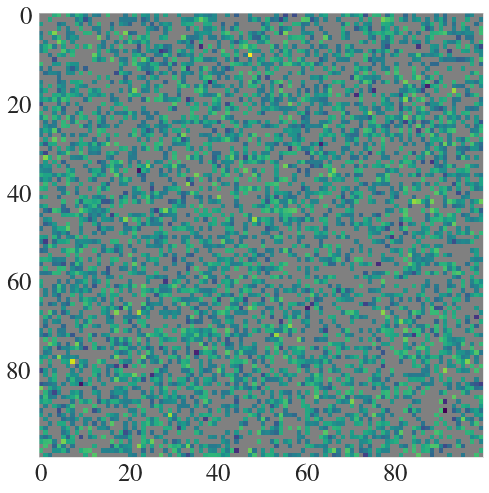

In [60]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

explenations_summed = xs_stroke_rcc_ltp.sum(axis=0)
explanations_nonzero = np.ma.masked_equal(explenations_summed, 0)

# Plot the mean of the explanations
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='gray')

plt.rcParams.update({
    'font.size': 25,
    'font.family': 'serif',
    'font.serif': ["Times"],
})
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
im = ax.imshow(explanations_nonzero, cmap=cmap, interpolation='nearest')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.2)
# fig.colorbar(im, cax=cax)

plt.savefig("lime-stroke.pdf", bbox_inches="tight")

In [16]:
explenations_summed.reshape(-1).min(), explenations_summed.reshape(-1).max()

(-0.0028471778575442793, 0.0018739433208596796)

/var/folders/bq/tb_cjs010kx_w5_vcqdxpr340000gn/T/ipykernel_39817/1119853281.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, orientation='horizontal')


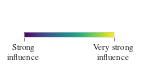

In [12]:
def plot_colorbar():

    # Create a dummy ScalarMappable object for the colorbar
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap=cmap, norm=norm)

    # Create the figure and set it to be very narrow for the colorbar
    fig, ax = plt.subplots(figsize=(COLUMN_WIDTH / 2, COLUMN_HIGHT / 4))
    ax.axis('off')

    # Create the colorbar with horizontal orientation
    cbar = fig.colorbar(sm, orientation='horizontal')
    cbar.set_ticks([0, 1], labels=['Strong\ninfluence', 'Very strong\ninfluence'])

    plt.savefig("colorbar.pdf", dpi=300, bbox_inches='tight')

plot_colorbar()